<a href="https://colab.research.google.com/github/ibixina/ML/blob/main/stocksTorn/torn_stocks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
lag_h6_filepath = "./stocksData/lag_h6.csv"

In [3]:
import pandas as pd

stockData = pd.read_csv(lag_h6_filepath)
stockData.head()

,Timestamp,Opening Price,High Price,Low Price,Closing Price,No of Shares
0,1726358400,445.06,445.53,444.70,445.24,8893652530
1,1726380000,445.24,445.66,444.79,445.61,8895471743
2,1726401600,445.63,447.18,445.61,446.89,8895194259
3,1726423200,446.90,448.07,446.90,447.92,8892811400
4,1726444800,447.95,448.67,447.72,448.15,8892452489


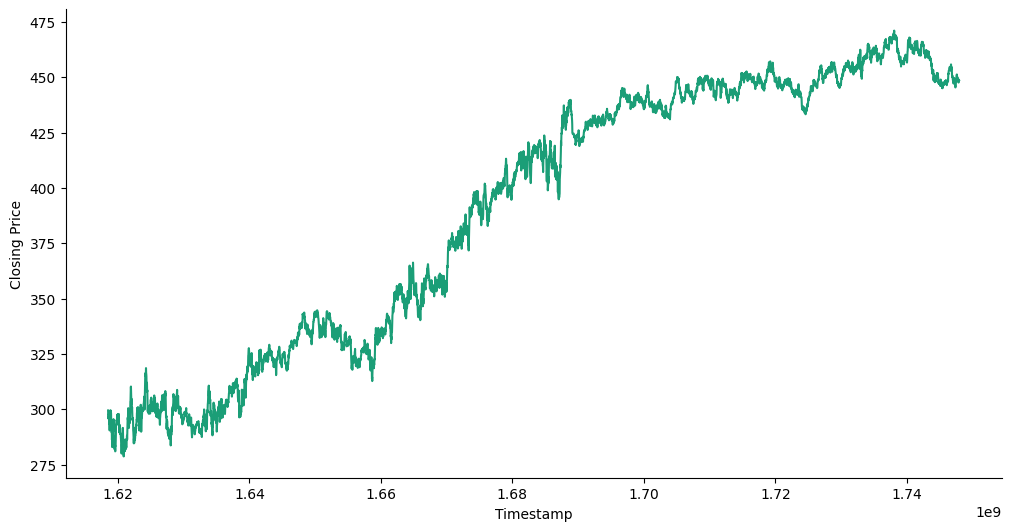

In [4]:
# @title Timestamp vs Closing Price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Closing Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = stockData.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Closing Price')

In [5]:
# only keep unique timestamps
stockDataCopy = stockData.copy()
stockDataCopy.drop_duplicates(subset=['Timestamp'], inplace=True)
stockDataCopy.shape

(5992, 6)

In [ ]:

stockDataCopy["NextValue"] = stockDataCopy["Low Price"].shift(-1)
stockDataCopy.dropna(inplace=True)
print(stockDataCopy.shape)
stockDataCopy.head()

# generate n lags

n_lags = 10
for i in range (1, n_lags + 1):
    stockDataCopy[f"Low Price Lag {i}"] = stockDataCopy["Low Price"].shift(i)
stockDataCopy.dropna(inplace=True)
print(stockDataCopy.shape)
stockDataCopy.head()


(5991, 7)
(5981, 17)


,Timestamp,Opening Price,High Price,Low Price,Closing Price,No of Shares,NextValue,Low Price Lag 1,Low Price Lag 2,Low Price Lag 3,Low Price Lag 4,Low Price Lag 5,Low Price Lag 6,Low Price Lag 7,Low Price Lag 8,Low Price Lag 9,Low Price Lag 10
10,1726574400,448.94,449.49,448.60,448.73,8256689623,448.63,448.14,448.46,448.00,448.25,448.17,447.72,446.90,445.61,444.79,444.70
11,1726596000,448.83,449.85,448.63,449.74,8253409201,449.65,448.60,448.14,448.46,448.00,448.25,448.17,447.72,446.90,445.61,444.79
12,1726617600,449.71,450.32,449.65,450.31,8253977917,450.16,448.63,448.60,448.14,448.46,448.00,448.25,448.17,447.72,446.90,445.61
13,1726639200,450.25,452.75,450.16,452.06,8258822266,451.53,449.65,448.63,448.60,448.14,448.46,448.00,448.25,448.17,447.72,446.90
14,1726660800,452.15,452.54,451.53,452.42,8256314545,452.25,450.16,449.65,448.63,448.60,448.14,448.46,448.00,448.25,448.17,447.72


In [7]:
from sklearn.model_selection import train_test_split

drop = ["Closing Price", "Opening Price", "High Price", "Timestamp", "No of Shares", "NextValue"]
df = stockDataCopy.copy()
X = df.drop(drop, axis=1)
y = df["NextValue"]


train_size = int(len(df) * 0.7)  # 70% for training
train_df = df[:train_size]
test_df = df[train_size:]

X_train = train_df.drop(drop, axis=1)
y_train = train_df["NextValue"]

X_test = test_df.drop(drop, axis=1)
y_test = test_df["NextValue"]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4186, 11) (1795, 11) (4186,) (1795,)


In [17]:
#model a sarima 2,1,3 model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(stockDataCopy["Low Price"], order=(2, 1, 3))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Low Price   No. Observations:                 5952
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -13451.488
Date:                Thu, 22 May 2025   AIC                          26914.977
Time:                        17:08:54   BIC                          26955.125
Sample:                             0   HQIC                         26928.925
                               - 5952                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1545      4.013      0.038      0.969      -7.711       8.020
ar.L2          0.7974      3.905      0.204      0.838      -6.856       8.451
ma.L1         -0.1192      4.013     -0.030      0.9

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming X_train, y_train, X_test, y_test are already created from the time-based split
# X_train and X_test should contain the lag features and other relevant features

# Reshape the input data for LSTM
# The number of time steps will be the number of lag features (excluding the 'Low Price' itself if it's in X)
# Let's assume X_train and X_test only contain the lag features and potentially other relevant features
# We need to determine the number of features per time step and the number of time steps (sequence length)

# Based on your previous code, X seems to contain "Low Price Lag 1" to "Low Price Lag 10"
# So, the number of time steps is 10, and the number of features per time step is 1 (the Low Price value at that lag)

# Let's verify the number of features in X_train to confirm the number of time steps
num_features = X_train.shape[1] # This should be the number of lag features + other features in X

# If X_train only contains the 'Low Price Lag X' columns (10 of them):
time_steps = num_features
n_features = 1 # One feature (Low Price) per time step in the sequence

# Reshape the data for LSTM
# We need to reshape each sample to be a sequence of time steps, where each time step has 'n_features'
# Current shape of X_train: (samples, num_features) -> e.g., (some_number, 10)
# Desired shape for LSTM: (samples, time_steps, n_features) -> e.g., (some_number, 10, 1)

X_train_lstm = X_train.values.reshape((X_train.shape[0], time_steps, n_features))
X_test_lstm = X_test.values.reshape((X_test.shape[0], time_steps, n_features))

# Reshape y for LSTM (optional, but good practice to have a consistent shape for prediction)
y_train_lstm = y_train.values.reshape((y_train.shape[0], 1))
y_test_lstm = y_test.values.reshape((y_test.shape[0], 1))

print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_test_lstm shape:", y_test_lstm.shape)

2025-05-23 23:52:44.230114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748044364.285472  198308 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748044364.298432  198308 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 23:52:44.432034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


X_train_lstm shape: (4186, 11, 1)
X_test_lstm shape: (1795, 11, 1)
y_train_lstm shape: (4186, 1)
y_test_lstm shape: (1795, 1)


In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, n_features))) # You can adjust the number of LSTM units
model.add(Dense(1)) # Output layer for a single prediction (the next Low Price)

model.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss for regression

model.summary()

2025-05-23 23:52:50.555964: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2409.8037 - val_loss: 35.6816
Epoch 2/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.7407 - val_loss: 40.2356
Epoch 3/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 14.3486 - val_loss: 29.0764
Epoch 4/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 16.7785 - val_loss: 31.8133
Epoch 5/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.4792 - val_loss: 26.6747
Epoch 6/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.4655 - val_loss: 28.6278
Epoch 7/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.1209 - val_loss: 29.3535
Epoch 8/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 86.1740 - val_loss: 58.5213
Epoch 9/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 39.9842 - val_loss: 26.3142
Epoch 10/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.0761 - val_loss: 25.6379
Epoch 11/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.9691 - val_loss: 23.8830
Epoch 12/150
240/240 ━━━━━━━━━━━━

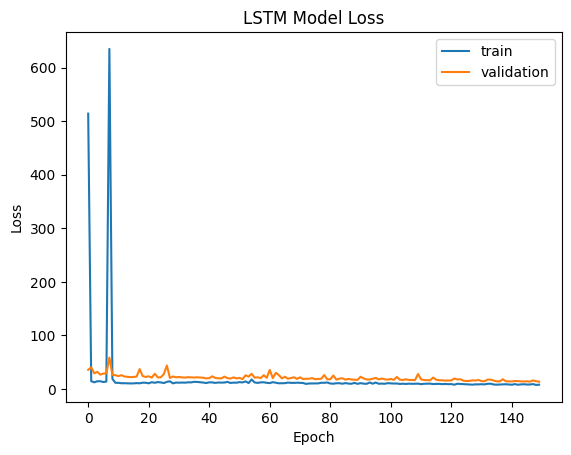

In [10]:
# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=14, validation_split=0.2, verbose=1)
# You can adjust epochs, batch_size, and validation_split

# Optional: Plot training history to see loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# can't use this due to the data being temporally dependent, so cannot randomize the dataset. implement a different method above.
# # test train data
# from sklearn.model_selection import train_test_split

# drop = ["Closing Price", "Opening Price", "High Price", "Timestamp", "No of Shares", "NextValue"]
# df = stockDataCopy.copy()
# X = df.drop(drop, axis=1)
# y = df["NextValue"]
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4186, 11) (1795, 11) (4186,) (1795,)


In [11]:
X.head(), y.head()

(    Low Price  Low Price Lag 1  Low Price Lag 2  Low Price Lag 3  \
 10     448.60           448.14           448.46           448.00   
 11     448.63           448.60           448.14           448.46   
 12     449.65           448.63           448.60           448.14   
 13     450.16           449.65           448.63           448.60   
 14     451.53           450.16           449.65           448.63   
 
     Low Price Lag 4  Low Price Lag 5  Low Price Lag 6  Low Price Lag 7  \
 10           448.25           448.17           447.72           446.90   
 11           448.00           448.25           448.17           447.72   
 12           448.46           448.00           448.25           448.17   
 13           448.14           448.46           448.00           448.25   
 14           448.60           448.14           448.46           448.00   
 
     Low Price Lag 8  Low Price Lag 9  Low Price Lag 10  
 10           445.61           444.79            444.70  
 11           44

In [12]:
print(X_test_lstm.shape)
print(model.input_shape)


(1795, 11, 1)
(None, 11, 1)


In [1]:
model.predict(X_test_lstm)

NameError: name 'model' is not defined

In [13]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f'LSTM Test Loss (MSE): {loss}')

model.summary()

# Make predictions on the test set
predictions_lstm = model.predict(X_test_lstm)

# You can compare these predictions to the actual y_test values
# For example, you can calculate RMSE or other metrics on the test set
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for sqrt

# Calculate MSE and then take the square root to get RMSE
mse_lstm = mean_squared_error(y_test_lstm, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm) # Take the square root to get RMSE
print(f'LSTM Test RMSE: {rmse_lstm}')

# To predict the next value based on the last sequence in the test set
# Ensure the shape is correct for prediction (1, time_steps, n_features)
last_sequence = X_test_lstm[-1].reshape(1, time_steps, n_features)
next_prediction_lstm = model.predict(last_sequence)
print(f'LSTM Next Prediction: {next_prediction_lstm}')

LSTM Test Loss (MSE): 3.39363431930542


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Test RMSE: 1.8421821813943484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
LSTM Next Prediction: [[325.11655]]


In [15]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
model.fit(X_train, y_train)

# 4. Evaluate the Model
predictions = model.predict(X_test)

# Evaluate using RMSE
rmse = mean_squared_error(y_test, predictions)
print(f'Linear Regression RMSE: {rmse}')

# print model summary
print(model.score(X_test, y_test))
r2 = r2_score(y_test, predictions)
print(f'Linear Regression R2: {r2}')

# predict the next data
next_data = X_test.iloc[-1].values.reshape(1, -1)
next_prediction = model.predict(next_data)
print(f'Next Prediction: {next_prediction}')


Linear Regression RMSE: 2.5683758361659503
0.9922586694255884
Linear Regression R2: 0.9922586694255884
Next Prediction: [325.86226324]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
